In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from sklearn.cluster import KMeans
import gym
from gym import spaces
import random
from collections import deque
import matplotlib.pyplot as plt


In [ ]:
ticker = 'AAPL'
data = yf.download(ticker, start='2018-01-01', end='2021-12-31')
prices = data['Close'].values

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [ ]:
window = 10

In [ ]:
# We create features such that each sample is the previous 'window' days of prices.
# Also, we compute the next-day return as the reward.
features = np.array([prices[i-window:i] for i in range(window, len(prices)-1)])
returns = np.array([(prices[i+1] - prices[i]) / prices[i] for i in range(window, len(prices)-1)])

n_samples = features.shape[0]
features = features.reshape(features.shape[0], features.shape[1])

print("Feature shape:", features.shape)
print("Returns shape:", returns.shape)


Feature shape: (996, 10)
Returns shape: (996, 1)


In [ ]:
latent_dim = 2
input_dim = features.shape[1]

# Build a simple dense autoencoder
input_layer = layers.Input(shape=(input_dim,))
encoded = layers.Dense(8, activation='relu')(input_layer)
encoded = layers.Dense(latent_dim, activation='linear')(encoded)

decoded = layers.Dense(8, activation='relu')(encoded)
decoded = layers.Dense(input_dim, activation='linear')(decoded)

autoencoder = models.Model(inputs=input_layer, outputs=decoded)
encoder = models.Model(inputs=input_layer, outputs=encoded)

autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

# Train the autoencoder
history = autoencoder.fit(features, features,
                          epochs=50,
                          batch_size=32,
                          shuffle=True,
                          verbose=0)

# Extract latent representations for all samples
latent_features = encoder.predict(features)
print("Latent features shape:", latent_features.shape)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 8)                   │              88 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │              18 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 8)                   │              24 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │              90 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 220 (880.00 B)

 Trainable params: 220 (880.00 B)

 Non-trainable params: 0 (0.00 B)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Latent features shape: (996, 2)


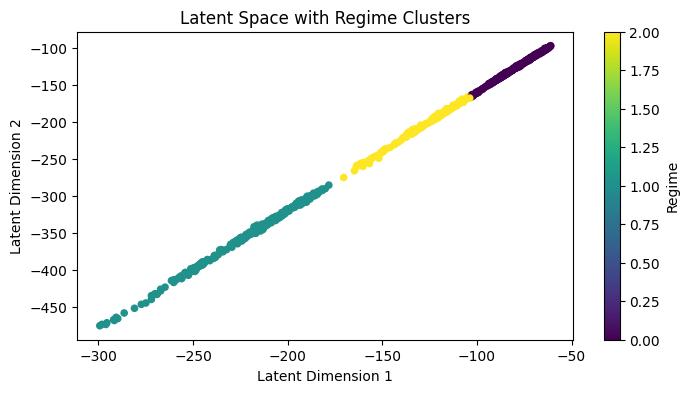

In [ ]:
n_regimes = 3
kmeans = KMeans(n_clusters=n_regimes, random_state=42)
regime_labels = kmeans.fit_predict(latent_features)
# Convert to one-hot vectors
regime_onehot = np.eye(n_regimes)[regime_labels]

# For visualization: Plot latent features colored by regime
plt.figure(figsize=(8, 4))
plt.scatter(latent_features[:, 0], latent_features[:, 1], c=regime_labels, cmap='viridis', s=20)
plt.title("Latent Space with Regime Clusters")
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.colorbar(label="Regime")
plt.show()

In [ ]:
class TradingEnv(gym.Env):
    """
    A basic trading environment.
    Observation: [latent representation (2 dims) + regime one-hot (3 dims)] = 5 dims total.
    Action space: Discrete(3) -> 0: hold, 1: long, 2: short.
    Reward: based on the next day’s return.
    """
    def __init__(self, latent_features, regime_onehot, returns):
        super(TradingEnv, self).__init__()
        self.latent_features = latent_features
        self.regime_onehot = regime_onehot
        self.returns = returns
        self.n_steps = len(returns)
        self.current_step = 0

        # Observation space: 5-dimensional vector (latent_dim + n_regimes)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(latent_dim + n_regimes,), dtype=np.float32)
        # Action space: 3 discrete actions: 0: hold, 1: long, 2: short.
        self.action_space = spaces.Discrete(3)

    def reset(self):
        self.current_step = 0
        return self._get_observation()

    def _get_observation(self):
        obs = np.concatenate([self.latent_features[self.current_step], self.regime_onehot[self.current_step]])
        return obs.astype(np.float32)

    def step(self, action):
        # Calculate reward based on action and next day's return
        ret = self.returns[self.current_step]
        if action == 1:  # long
            reward = ret
        elif action == 2:  # short
            reward = -ret
        else:
            reward = 0.0

        self.current_step += 1
        done = self.current_step >= self.n_steps
        next_obs = self._get_observation() if not done else np.zeros(self.observation_space.shape)
        return next_obs, reward, done, {}

    def render(self, mode='human'):
        pass

# Initialize environment
env = TradingEnv(latent_features, regime_onehot, returns)
obs = env.reset()
print("Initial observation:", obs)

Initial observation: [ -69.80446  -111.927704    1.          0.          0.      ]


In [ ]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = 0.99  # discount factor
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.05
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.batch_size = 32
        self.memory = deque(maxlen=2000)

        self.model = self._build_model()

    def _build_model(self):
        model = models.Sequential()
        model.add(layers.Dense(16, input_dim=self.state_size, activation='relu'))
        model.add(layers.Dense(16, activation='relu'))
        model.add(layers.Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=optimizers.Adam(learning_rate=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        q_values = self.model.predict(state[np.newaxis, :], verbose=0)
        return np.argmax(q_values[0])

    def replay(self):
        if len(self.memory) < self.batch_size:
            return

        minibatch = random.sample(self.memory, self.batch_size)
        states = np.array([s for s, a, r, ns, d in minibatch])
        targets = self.model.predict(states, verbose=0)

        next_states = np.array([ns for s, a, r, ns, d in minibatch])
        q_next = self.model.predict(next_states, verbose=0)

        for i, (state, action, reward, next_state, done) in enumerate(minibatch):
            if done:
                targets[i][action] = reward
            else:
                targets[i][action] = reward + self.gamma * np.amax(q_next[i])
        self.model.fit(states, targets, epochs=1, verbose=0)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

state_size = latent_dim + n_regimes  # 2 + 3 = 5
action_size = env.action_space.n
agent = DQNAgent(state_size, action_size)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


<ipython-input-8-bd3053b38480>:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  targets[i][action] = reward + self.gamma * np.amax(q_next[i])


Episode 1/7 - Total Reward: 0.3430 - Epsilon: 0.0499
Episode 2/7 - Total Reward: -0.0828 - Epsilon: 0.0499
Episode 3/7 - Total Reward: 0.1436 - Epsilon: 0.0499
Episode 4/7 - Total Reward: 0.2876 - Epsilon: 0.0499
Episode 5/7 - Total Reward: 0.7564 - Epsilon: 0.0499
Episode 6/7 - Total Reward: 0.8101 - Epsilon: 0.0499
Episode 7/7 - Total Reward: 0.0323 - Epsilon: 0.0499


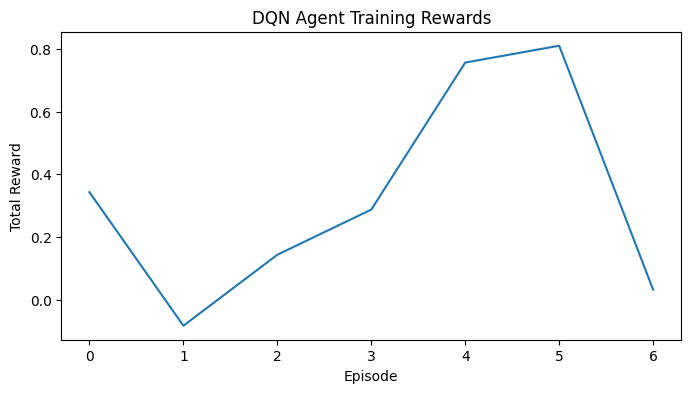

In [ ]:
episodes = 7
reward_history = []

for e in range(episodes):
    state = env.reset()
    total_reward = 0.0
    done = False
    while not done:
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward
        agent.replay()
    reward_history.append(total_reward)
    print(f"Episode {e+1}/{episodes} - Total Reward: {float(total_reward):.4f} - Epsilon: {agent.epsilon:.4f}")

# Plot episode rewards
plt.figure(figsize=(8, 4))
plt.plot(reward_history)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("DQN Agent Training Rewards")
plt.show()


In [ ]:
train_data = data.loc[:'2020-01-01']
test_data = data.loc['2020-01-02':]

# Use the adjusted close price (if auto_adjust=True, then 'Close' column)
train_prices = train_data['Close'].values
test_prices = test_data['Close'].values


In [ ]:
window = 10
# Create features for test period
test_features = np.array([test_prices[i-window:i] for i in range(window, len(test_prices)-1)])
test_returns = np.array([(test_prices[i+1] - test_prices[i]) / test_prices[i]
                          for i in range(window, len(test_prices)-1)])

# If needed, reshape to remove extra dimensions (if shape is (n, window, 1))
if test_features.ndim == 3 and test_features.shape[2] == 1:
    test_features = test_features.reshape(test_features.shape[0], test_features.shape[1])

In [ ]:
latent_features_test = encoder.predict(test_features)
# Use the same KMeans model to predict regimes on test data
regime_labels_test = kmeans.predict(latent_features_test)
regime_onehot_test = np.eye(n_regimes)[regime_labels_test]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


In [ ]:
# -------------------------------
# Extended Trading Environment with Transaction Costs & Leverage
# -------------------------------
class TradingEnvExtended(gym.Env):
    """
    Extended trading environment that includes transaction costs and leverage.
    Observation: [latent representation (2 dims) + regime one-hot (3 dims)] = 5 dims total.
    Action space: Discrete(3) -> 0: hold, 1: long, 2: short.
    Reward: next-day return (long/short), scaled by leverage and penalized by transaction cost on position changes.
    """
    def __init__(self, latent_features, regime_onehot, returns, transaction_cost=0.0, leverage=1.0):
        super(TradingEnvExtended, self).__init__()
        self.latent_features = latent_features
        self.regime_onehot = regime_onehot
        self.returns = returns
        self.n_steps = len(returns)
        self.current_step = 0
        self.transaction_cost = transaction_cost
        self.leverage = leverage
        self.prev_action = 0  # starting with 'hold'

        self.observation_space = spaces.Box(low=-np.inf, high=np.inf,
                                             shape=(latent_dim + n_regimes,), dtype=np.float32)
        self.action_space = spaces.Discrete(3)

    def reset(self):
        self.current_step = 0
        self.prev_action = 0
        return self._get_observation()

    def _get_observation(self):
        obs = np.concatenate([self.latent_features[self.current_step],
                              self.regime_onehot[self.current_step]])
        return obs.astype(np.float32)

    def step(self, action):
        ret = self.returns[self.current_step]
        # Apply leverage: effective return
        effective_ret = self.leverage * ret

        # Reward calculation based on action
        if action == 1:  # long
            reward = effective_ret
        elif action == 2:  # short
            reward = -effective_ret
        else:
            reward = 0.0

        # Apply transaction cost if the action changes
        if action != self.prev_action:
            reward -= self.transaction_cost

        self.prev_action = action
        self.current_step += 1
        done = self.current_step >= self.n_steps
        next_obs = self._get_observation() if not done else np.zeros(self.observation_space.shape)
        return next_obs, reward, done, {}

    def render(self, mode='human'):
        pass

In [ ]:
# -------------------------------
# Evaluate the Agent on Out-of-Sample Data
# -------------------------------
# Create out-of-sample environment (initially without transaction costs or leverage adjustments)
test_env = TradingEnvExtended(latent_features_test, regime_onehot_test, test_returns,
                              transaction_cost=0.0, leverage=1.0)

def evaluate_agent(env, agent):
    state = env.reset()
    total_reward = 0.0
    done = False
    while not done:
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        total_reward += reward
        state = next_state
    return total_reward

test_reward = evaluate_agent(test_env, agent)
print("Out-of-sample total reward (no transaction cost, leverage=1.0):", test_reward)

Out-of-sample total reward (no transaction cost, leverage=1.0): [-0.84036216]


In [ ]:
tc_values = [0.0, 0.001, 0.005, 0.01]
results_tc = {}
print("\nTransaction Cost Sensitivity Analysis:")
for tc in tc_values:
    env_temp = TradingEnvExtended(latent_features_test, regime_onehot_test, test_returns,
                                  transaction_cost=tc, leverage=1.0)
    reward_tc = evaluate_agent(env_temp, agent)
    results_tc[tc] = reward_tc
    print(f"Transaction cost {tc:.3f}: Total Reward = {float(reward_tc):.4f}")



Transaction Cost Sensitivity Analysis:


<ipython-input-17-b99353236bd5>:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"Transaction cost {tc:.3f}: Total Reward = {float(reward_tc):.4f}")


Transaction cost 0.000: Total Reward = -0.5475
Transaction cost 0.001: Total Reward = -0.4687
Transaction cost 0.005: Total Reward = -0.8022
Transaction cost 0.010: Total Reward = -1.2003


In [ ]:
lev_values = [0.5, 1.0, 2.0, 3.0]
results_lev = {}
print("\nLeverage Sensitivity Analysis:")
for lev in lev_values:
    env_temp = TradingEnvExtended(latent_features_test, regime_onehot_test, test_returns,
                                  transaction_cost=0.0, leverage=lev)
    reward_lev = evaluate_agent(env_temp, agent)
    results_lev[lev] = reward_lev
    print(f"Leverage {lev:.1f}: Total Reward = {float(reward_lev):.4f}")



Leverage Sensitivity Analysis:


<ipython-input-20-f69bd93cd463>:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"Leverage {lev:.1f}: Total Reward = {float(reward_lev):.4f}")


Leverage 0.5: Total Reward = -0.2536
Leverage 1.0: Total Reward = -0.3962
Leverage 2.0: Total Reward = -1.1695
Leverage 3.0: Total Reward = -0.8981


In [ ]:
benchmark_cumulative_return = np.prod(1 + test_returns) - 1
print("\nBenchmark Buy-and-Hold Cumulative Return (Out-of-Sample):", benchmark_cumulative_return)



Benchmark Buy-and-Hold Cumulative Return (Out-of-Sample): 1.2947208330484359


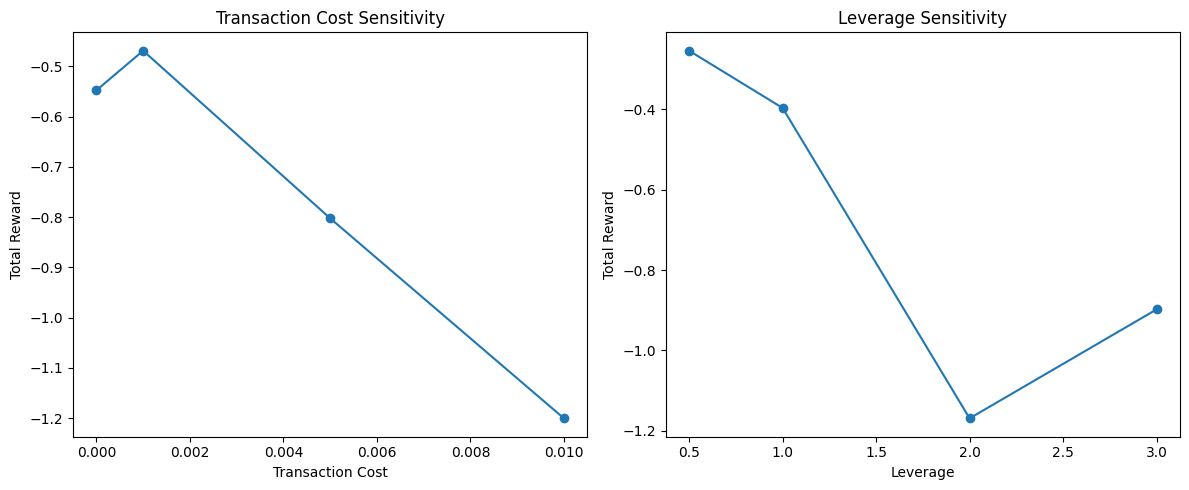

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(list(results_tc.keys()), list(results_tc.values()), marker='o')
plt.xlabel("Transaction Cost")
plt.ylabel("Total Reward")
plt.title("Transaction Cost Sensitivity")

plt.subplot(1, 2, 2)
plt.plot(list(results_lev.keys()), list(results_lev.values()), marker='o')
plt.xlabel("Leverage")
plt.ylabel("Total Reward")
plt.title("Leverage Sensitivity")

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import gym
from gym import spaces
import random
from collections import deque

window_momentum = 5
momentum_signal = []
for i in range(window_momentum, len(test_prices)):
    signal = 1 if test_prices[i] > test_prices[i - window_momentum] else -1
    momentum_signal.append(signal)
momentum_signal = np.array(momentum_signal)


In [ ]:
# (B) Mean-Reversion Signal:
# Use a 10-day moving average; signal = -1 if current price is above the moving average (indicating overvaluation), else +1.
test_prices = test_prices.flatten()
moving_avg = pd.Series(test_prices).rolling(window=ma_window).mean().to_numpy()

mean_reversion_signal = []
for i in range(ma_window, len(test_prices)):
    signal = -1 if test_prices[i] > moving_avg[i] else 1
    mean_reversion_signal.append(signal)
mean_reversion_signal = np.array(mean_reversion_signal)


In [ ]:
def simulate_agent_actions(env, agent):
    state = env.reset()
    actions = []
    done = False
    while not done:
        action = agent.act(state)
        actions.append(action)
        state, reward, done, _ = env.step(action)
    return np.array(actions)

# Simulate and convert actions:
# Agent actions: 0 = hold, 1 = long, 2 = short. We'll map these to signals: 1 for long, -1 for short, and 0 for hold.
rl_actions = simulate_agent_actions(test_env, agent)
rl_signal = np.where(rl_actions == 1, 1, np.where(rl_actions == 2, -1, 0))

# Our test_returns length is: len(test_prices) - window - 1.
# Momentum signal length: len(test_prices) - window_momentum.
# Mean reversion length: len(test_prices) - ma_window.
min_length = min(len(test_returns), len(momentum_signal), len(mean_reversion_signal), len(rl_signal))

# Align each signal to the most recent min_length samples.
test_returns_adj = test_returns[-min_length:]
momentum_signal = momentum_signal[-min_length:]
mean_reversion_signal = mean_reversion_signal[-min_length:]
rl_signal = rl_signal[-min_length:]

# For demonstration, use a simple majority vote: sum the signals and take the sign.
# (If sum = 0, signal remains 0.)
composite_signal = np.sign(rl_signal + momentum_signal + mean_reversion_signal)

# Assume: if composite_signal == 1, strategy return = test_returns_adj; if composite_signal == -1, strategy return = -test_returns_adj; if 0, return 0.
composite_returns = np.where(composite_signal == 1, test_returns_adj,
                             np.where(composite_signal == -1, -test_returns_adj, 0))

# Compute daily cumulative returns:
daily_cumprod = np.cumprod(1 + composite_returns)
cumulative_returns = daily_cumprod - 1

def max_drawdown(cum_returns):
    peaks = np.maximum.accumulate(cum_returns)
    drawdowns = (cum_returns - peaks) / peaks
    return np.min(drawdowns)

def sharpe_ratio(returns, risk_free_rate=0.0):
    # Annualize assuming 252 trading days.
    excess_returns = returns - risk_free_rate / 252
    return np.mean(excess_returns) / np.std(excess_returns) * np.sqrt(252)

final_cum_return = cumulative_returns[-1]
max_dd = max_drawdown(daily_cumprod)
sharpe = sharpe_ratio(composite_returns)

print("Composite Strategy Final Cumulative Return:", final_cum_return)
print("Composite Strategy Max Drawdown:", max_dd)
print("Composite Strategy Sharpe Ratio:", sharpe)



Composite Strategy Final Cumulative Return: -1.0
Composite Strategy Max Drawdown: -1.0
Composite Strategy Sharpe Ratio: -0.46153606974585054
